In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0' 
from time import time
import numpy as np
numSeed = 42
np.random.seed(numSeed)
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))

import sys  
sys.path.append('../')
from util.util import *

Using TensorFlow backend.


## Declare the parameters

In [2]:
numEpochs = 50
sizeBatch = 64
layerDense = [512, 512, 2]
dimEncode = layerDense[-1]
factNoise = 0
actDense = 'relu'
nameOptim = 'adam'

## Load the datasets

In [3]:
(xTrain, _), (xTest, yTest) = mnist.load_data()
xTrain = (xTrain.astype('float32') - 127.5) / 127.5
xTest = (xTest.astype('float32') - 127.5) / 127.5
numTrain = len(xTrain)
numTest = len(xTest)
dimInput = np.prod(xTrain.shape[1:])
sizeDigit = xTrain.shape[1]

xTrain = xTrain.reshape(numTrain, dimInput)
xTest = xTest.reshape(numTest, dimInput)
xTrainNoise = addNoise(xTrain, factNoise=factNoise)
xTestNoise = addNoise(xTest, factNoise=factNoise)
print(xTrain.shape)
print(xTest.shape)

(60000, 784)
(10000, 784)


In [4]:
inputsDis = Input(shape=(dimEncode,))
x = Dense(512, activation='relu')(inputsDis)
x = Dense(256, activation='relu')(x)
validityDis = Dense(1, activation="sigmoid")(x)
discriminator = Model(inputsDis, validityDis)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=nameOptim,
                      metrics=['accuracy'])
discriminator.trainable = False

## Construct the encoder and decoder

In [5]:
inputs = Input(shape=(dimInput,))
x = inputs
for numFilt in layerDense:
    x = Dense(numFilt, activation=actDense)(x)
encoder = Model(inputs, x, name='encoder')

inputLatent = Input(shape=(dimEncode,))
x = inputLatent
for numFilt in layerDense[-2::-1]:
    x = Dense(numFilt, activation=actDense)(x)
x = Dense(dimInput, activation='sigmoid')(x)
decoder = Model(inputLatent, x, name='decoder')

encoder.summary()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 1026      
Total params: 665,602
Trainable params: 665,602
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dens

## Construct the autoencoder

In [6]:
autoencoder = Model(inputs, [decoder(encoder(inputs)), discriminator(encoder(inputs))])
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 2)            665602      input_2[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
decoder (Model)                 (None, 784)          666384      encoder[1][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            133121      encoder[2][0]                    
Total para

## Compile and train

In [7]:
autoencoder.compile(optimizer=nameOptim, loss=['mse', 'binary_crossentropy'], loss_weights=[0.999, 0.001])

tic = time()
# Adversarial ground truths
valid = np.ones((sizeBatch, 1))
fake = np.zeros((sizeBatch, 1))
for epoch in range(numEpochs):
    for iBatch in range(int(numTrain/sizeBatch)):
        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of images
        idx = np.random.randint(0, xTrain.shape[0], sizeBatch)
        imgs = xTrain[idx]

        latent_fake = encoder.predict(imgs)
        latent_real = np.random.normal(size=(sizeBatch, dimEncode))

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(latent_real, valid)
        d_loss_fake = discriminator.train_on_batch(latent_fake, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Train the generator
        g_loss = autoencoder.train_on_batch(imgs, [imgs, valid])

    # Plot the progress
    print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))


# history = autoencoder.fit(xTrainNoise, xTrain,
#                 epochs=numEpochs,
#                 sizeBatch=sizeBatch,
#                 shuffle=True,
#                 validation_data=(xTest, xTest))
timeTrain = time() - tic

/opt/anaconda3/envs/py36/lib/python3.6/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.000124, acc: 100.00%] [G loss: 0.940378, mse: 0.925185]
1 [D loss: 0.000003, acc: 100.00%] [G loss: 0.937322, mse: 0.922126]
2 [D loss: 0.000000, acc: 100.00%] [G loss: 0.938919, mse: 0.923725]
3 [D loss: 0.000000, acc: 100.00%] [G loss: 0.937898, mse: 0.922703]
4 [D loss: 0.000007, acc: 100.00%] [G loss: 0.944951, mse: 0.929762]
5 [D loss: 0.000001, acc: 100.00%] [G loss: 0.941976, mse: 0.926785]
6 [D loss: 0.000000, acc: 100.00%] [G loss: 0.937963, mse: 0.922768]
7 [D loss: 0.000000, acc: 100.00%] [G loss: 0.937067, mse: 0.921870]
8 [D loss: 0.000000, acc: 100.00%] [G loss: 0.940651, mse: 0.925458]
9 [D loss: 0.000000, acc: 100.00%] [G loss: 0.940473, mse: 0.925280]
10 [D loss: 0.000000, acc: 100.00%] [G loss: 0.939372, mse: 0.924178]
11 [D loss: 0.000000, acc: 100.00%] [G loss: 0.943314, mse: 0.928124]
12 [D loss: 0.000000, acc: 100.00%] [G loss: 0.938892, mse: 0.923698]
13 [D loss: 0.000000, acc: 100.00%] [G loss: 0.944703, mse: 0.929514]
14 [D loss: 0.000000, acc: 100

## Show the historical training progress 

In [42]:
print("traing consumed: " + str(timeTrain) + " seconds")
plotProgress(history)

traing consumed: 337.5658712387085 seconds


NameError: name 'history' is not defined

## Get the encoding and decoding results of testing data, and get the mean/std of the encoding 

In [8]:
# encode and decode some digits
# note that we take them from the *test* set
encodeTest = encoder.predict(xTest)
decodeTest = decoder.predict(encodeTest)
meanEncTest = np.mean(encodeTest, axis=0)
stdEncTest = np.std(encodeTest, axis=0)

## Compare original digitals with the decoding results

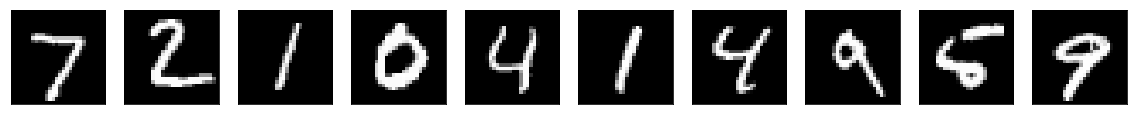

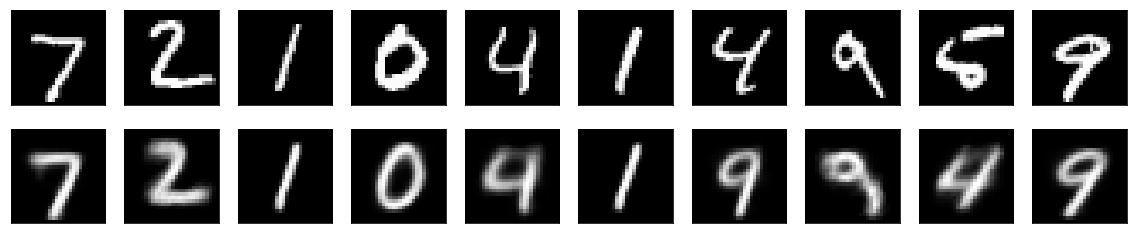

In [9]:
plotCompDecode(xTest, decodeTest, xNoise=xTestNoise)


## Plot the scatter of the encoding space

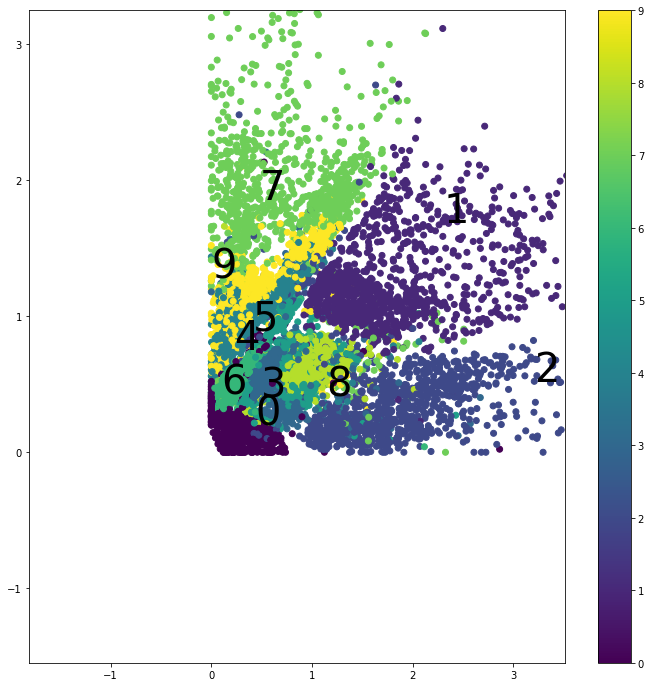

In [10]:
xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])

plotScatterEncode(encodeTest, yTest, xlim, ylim, numShow=10000)
scoreSilh = silhouette_score(encodeTest, yTest)  

## Plot the decoding results from the encoding scatter 

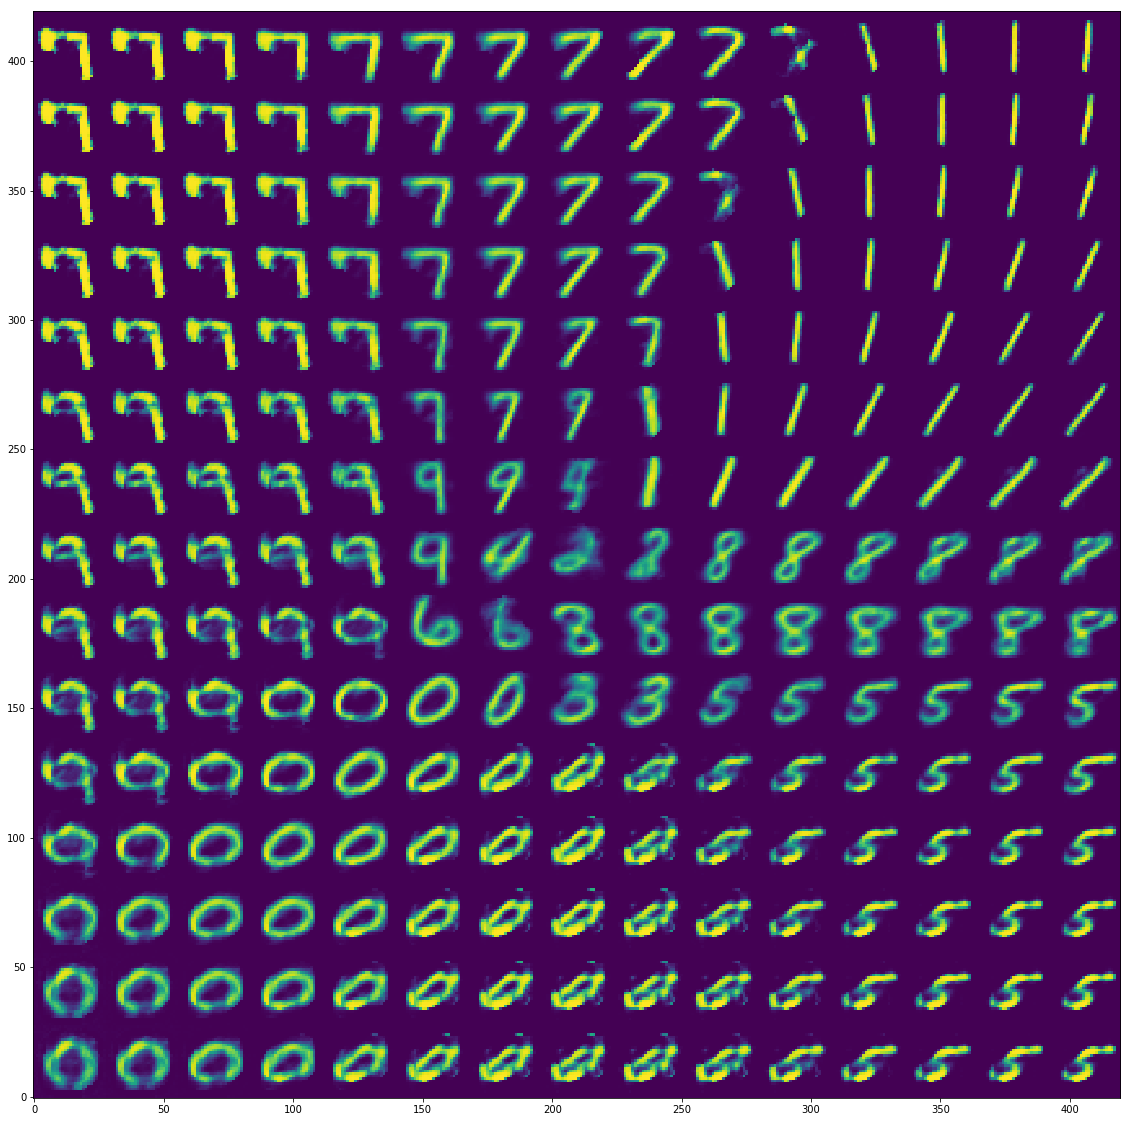

In [11]:
# display a 2D manifold of the digits
plotScatterDecode(decoder, (sizeDigit, sizeDigit), xlim, ylim)

In [ ]:
print(timeTrain, history.history["loss"][numEpochs-1], history.history["val_loss"][numEpochs-1], scoreSilh)

In [15]:
np.save("../test/yTest_mnist",yTest)